In [139]:
import sys
sys.path.insert(0, '..')

In [140]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [141]:
wid = 64
oversample = 4

optics = NICMOSOptics(1024, wid, oversample)

detector = NICMOSDetector(oversample, wid)
ddir = "../data/MAST_2024-08-27T07_49_07.684Z/"
#ddir = '../data/MAST_2024-07-07T03_17_36.223Z/'
#fname = ddir + 'HST/n8ku01050_mos.fits'
#fname = ddir + 'HST/n8ku01ffq_cal.fits'
ddir = "../data/MAST_2024-09-08T07_59_18.213Z/"
fname = ddir + 'HST/n43ca5feq_cal.fits'
#fname = ddir + 'HST/n43ca5fkq_cal.fits'

new_nans = True

if new_nans:
    bad = np.zeros((wid,wid), dtype=int)

#ddir = "../data/MAST_2024-09-10T09_18_21.143Z/"
ddir = "../data/MAST_2024-09-10T11_15_30.133Z/"

ddir = "../data/MAST_2024-09-08T07_59_18.213Z/"


exposures = [
# P330-E F090M
    #exposure_from_file(ddir + 'HST/n8e505trq_cal.fits', SinglePointFit(), crop=wid, extra_bad=None),
    #exposure_from_file(ddir + 'HST/n8e505tsq_cal.fits', SinglePointFit(), crop=wid, extra_bad=None),
    #exposure_from_file(ddir + 'HST/n8e505ttq_cal.fits', SinglePointFit(), crop=wid, extra_bad=None),
    #exposure_from_file(ddir + 'HST/n8e505tqq_cal.fits', SinglePointFit(), crop=wid, extra_bad=None),
    
    #exposure_from_file(ddir + 'HST/n8e504rlq_cal.fits', SinglePointFit(), crop=wid, extra_bad=None),

    #exposure_from_file(ddir + 'HST/n8vi01d2q_cal.fits', AberratedSinglePointFit(), crop=wid, extra_bad=None),

# SAO 179809

    exposure_from_file(ddir + 'HST/n43ca5feq_cal.fits', SinglePointFit(), crop=wid, extra_bad=bad),
    #exposure_from_file(ddir + 'HST/n43ca5ffq_cal.fits', SinglePointFit(), crop=wid, extra_bad=bad),
    #exposure_from_file(ddir + 'HST/n43ca5fgq_cal.fits', SinglePointFit(), crop=wid, extra_bad=bad),
    #exposure_from_file(ddir + 'HST/n43ca5fhq_cal.fits', SinglePointFit(), crop=wid, extra_bad=bad),
    #exposure_from_file(ddir + 'HST/n43ca5fjq_cal.fits', SinglePointFit(), crop=wid, extra_bad=bad),
    #exposure_from_file(ddir + 'HST/n43ca5fkq_cal.fits', SinglePointFit(), crop=wid, extra_bad=bad),
    #exposure_from_file(ddir + 'HST/n43ca5flq_cal.fits', SinglePointFit(), crop=wid, extra_bad=bad),
    #exposure_from_file(ddir + 'HST/n43ca5fmq_cal.fits', SinglePointFit(), crop=wid, extra_bad=bad),

# LHS 1846
    #exposure_from_file("../data/MAST_2024-08-27T07_49_07.684Z/HST/n8ku01ffq_cal.fits", AberratedSinglePointFit(),crop=wid)
]

In [142]:
exposures[0].filter

'F190N'

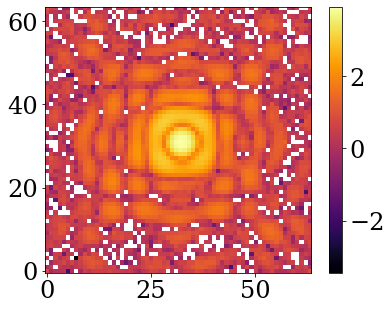

In [143]:
plt.imshow(np.log10(exposures[0].data/exposures[0].err))
plt.colorbar()

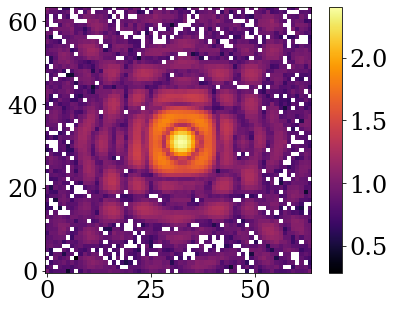

In [144]:
plt.imshow(exposures[0].data**0.125)
plt.colorbar()

In [145]:
params = {
    "fluxes": {},
    "positions": {},
    "slope": {},
    "aberrations": {},
    #"breathing": {},
    #"end_aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0434735,
    "rot": 0.0,
    "softening": 2,
}

for exp in exposures:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["fluxes"][exp.fit.get_key(exp, "fluxes")] = np.log10(np.nansum(exp.data))
    params["slope"][exp.fit.get_key(exp, "slope")] = np.zeros(5)
    #params["aberrations"] = injected_params["aberrations"]
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(19)
    #params["breathing"][exp.fit.get_key(exp, "breathing")] = np.zeros(19) + 0.1
    #params["start_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)#jr.uniform(jr.key(0), (8,),minval=-4e-8, maxval=4e-8) #np.asarray([-8.59023084e-10,  1.77049982e-09, -4.45293089e-09, -3.70890613e-08,2.03658617e-08,  1.08092528e-08, -2.77077727e-09,  1.86458672e-09])*0.9#jr.uniform(jr.key(0), (8,),minval=-2e-8, maxval=2e-8)#np.zeros(8)#np.ones(8)*1e-8
    #params["end_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([0.06, 0.06])*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = 45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] =  45.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])

model = set_array(NICMOSModel(exposures, params, optics, detector))

params = ModelParams(params)

In [146]:
params

ModelParams(
  params={
    'fluxes':
    {'F190N': f32[]},
    'positions':
    {'n43ca5feq': f32[2]},
    'slope':
    {'F190N': f32[5]},
    'aberrations':
    {'n43ca5feq': f32[19]},
    'cold_mask_shift':
    {'F190N': f32[2]},
    'cold_mask_rot':
    {'F190N': 45.0},
    'cold_mask_scale':
    {'F190N': f32[2]},
    'cold_mask_shear':
    {'F190N': f32[2]},
    'primary_scale':
    {'F190N': f32[2]},
    'primary_rot':
    {'F190N': 45.0},
    'primary_shear':
    {'F190N': f32[2]},
    'outer_radius':
    1.146,
    'secondary_radius':
    0.44639999999999996,
    'spider_width':
    0.0924,
    'scale':
    0.0434735,
    'rot':
    0.0,
    'softening':
    2
  }
)

In [147]:
print(params.params)

{'fluxes': {'F190N': Array(4.48267, dtype=float32)}, 'positions': {'n43ca5feq': Array([0., 0.], dtype=float32)}, 'slope': {'F190N': Array([0., 0., 0., 0., 0.], dtype=float32)}, 'aberrations': {'n43ca5feq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'cold_mask_shift': {'F190N': Array([6., 6.], dtype=float32)}, 'cold_mask_rot': {'F190N': 45.0}, 'cold_mask_scale': {'F190N': Array([1., 1.], dtype=float32)}, 'cold_mask_shear': {'F190N': Array([0., 0.], dtype=float32)}, 'primary_scale': {'F190N': Array([1., 1.], dtype=float32)}, 'primary_rot': {'F190N': 45.0}, 'primary_shear': {'F190N': Array([0., 0.], dtype=float32)}, 'outer_radius': 1.146, 'secondary_radius': 0.44639999999999996, 'spider_width': 0.0924, 'scale': 0.0434735, 'rot': 0.0, 'softening': 2}


In [148]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 1e-3

things = {
    "fluxes" : opt(g*50,10),
    "positions": opt(g*50, 0),
    "cold_mask_shift": opt(g*500, 50),
    #"cold_mask_rot": opt(g*100, 50),
    #"scale": opt(g*8, 20),
    "cold_mask_scale": opt(g*100, 50),
    "cold_mask_rot": opt(g*100, 50),
    "cold_mask_shear": opt(g*100, 50),
    #"primary_scale": opt(g*100, 50),
    #"primary_rot": opt(g*100, 50),
    #"primary_shear": opt(g*100, 50),
    "aberrations": opt(g*1.5,25),
    #"breathing": opt(g*300,150),
    #"rot": opt(g*100, 50),
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [149]:
@zdx.filter_jit
@zdx.filter_value_and_grad(paths)
def loss_fn(params,exposures):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))


In [150]:
#loss_fn(params, exposures)[1].params

In [151]:
rc = False
fishers = calc_fishers(model, exposures, paths, recalculate=rc)
lrs = calc_lrs(model, exposures, fishers, paths)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [152]:
lrs.params

{'aberrations': {'n43ca5feq': Array([-0.00266544,  0.00141713,  0.00124731, -0.0009729 , -0.00082478,
         -0.00066551, -0.00066794, -0.00323081,  0.0371161 ,  0.01453127,
          0.00805624,  0.00370208, -0.00298585, -0.00793667, -0.00110011,
         -0.00111195,  0.0352467 ,  0.04860396,  0.00176841], dtype=float32)},
 'cold_mask_rot': {'F190N': Array(3.517071e-07, dtype=float32)},
 'cold_mask_scale': {'F190N': Array([1.4238667e-10, 1.4038239e-10], dtype=float32)},
 'cold_mask_shear': {'F190N': Array([8.322672e-07, 8.295256e-07], dtype=float32)},
 'cold_mask_shift': {'F190N': Array([7.562862e-07, 7.499932e-07], dtype=float32)},
 'fluxes': {'F190N': Array(-2.925649e-10, dtype=float32)},
 'outer_radius': None,
 'positions': {'n43ca5feq': Array([-9.024446e-09, -8.409608e-09], dtype=float32)},
 'primary_rot': {'F190N': None},
 'primary_scale': {'F190N': None},
 'primary_shear': {'F190N': None},
 'rot': None,
 'scale': None,
 'secondary_radius': None,
 'slope': {'F190N': None},
 's

In [153]:
optim, opt_state = zdx.get_optimiser(
    params, groups, optimisers
)


losses, models = [], []
for i in tqdm(range(300)):
    loss, grads = loss_fn(params,exposures)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, ModelParams(lrs.params))
    updates, opt_state = optim.update(grads, opt_state)
    params = zdx.apply_updates(params, updates)

    #if i == 200:
    #    params.set("softening", 0.2)

    models.append(params)
    losses.append(loss)


  0%|          | 0/300 [00:00<?, ?it/s]

In [154]:
#model


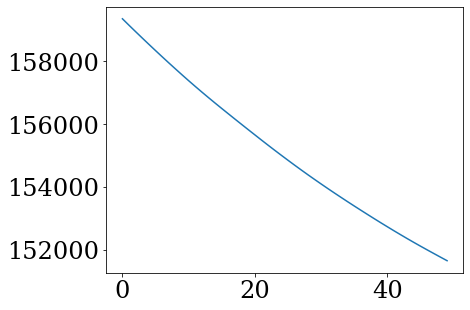

In [155]:
plt.plot(losses[-50:])

In [156]:
params.params

{'aberrations': {'n43ca5feq': Array([  1.9805312 ,  -0.18335393,  -1.0153775 ,   4.406505  ,
          11.726224  ,   3.7957184 ,   1.2508667 ,  -7.4754815 ,
         -30.541945  ,   2.412988  , -13.0434675 ,  -4.6792164 ,
         -21.322643  ,  -5.829957  ,  -0.7086347 ,  -6.063102  ,
           1.0436665 ,  -0.7148576 ,  -1.503717  ], dtype=float32)},
 'cold_mask_rot': {'F190N': Array(44.961506, dtype=float32)},
 'cold_mask_scale': {'F190N': Array([1.0125065, 1.0028905], dtype=float32)},
 'cold_mask_shear': {'F190N': Array([-0.08796688, -0.18889529], dtype=float32)},
 'cold_mask_shift': {'F190N': Array([9.6375265, 6.8858953], dtype=float32)},
 'fluxes': {'F190N': Array(4.51099, dtype=float32)},
 'outer_radius': 1.146,
 'positions': {'n43ca5feq': Array([ 0.82444865, -0.6586028 ], dtype=float32)},
 'primary_rot': {'F190N': 45.0},
 'primary_scale': {'F190N': Array([1., 1.], dtype=float32)},
 'primary_shear': {'F190N': Array([0., 0.], dtype=float32)},
 'rot': 0.0,
 'scale': 0.0434735,
 

7


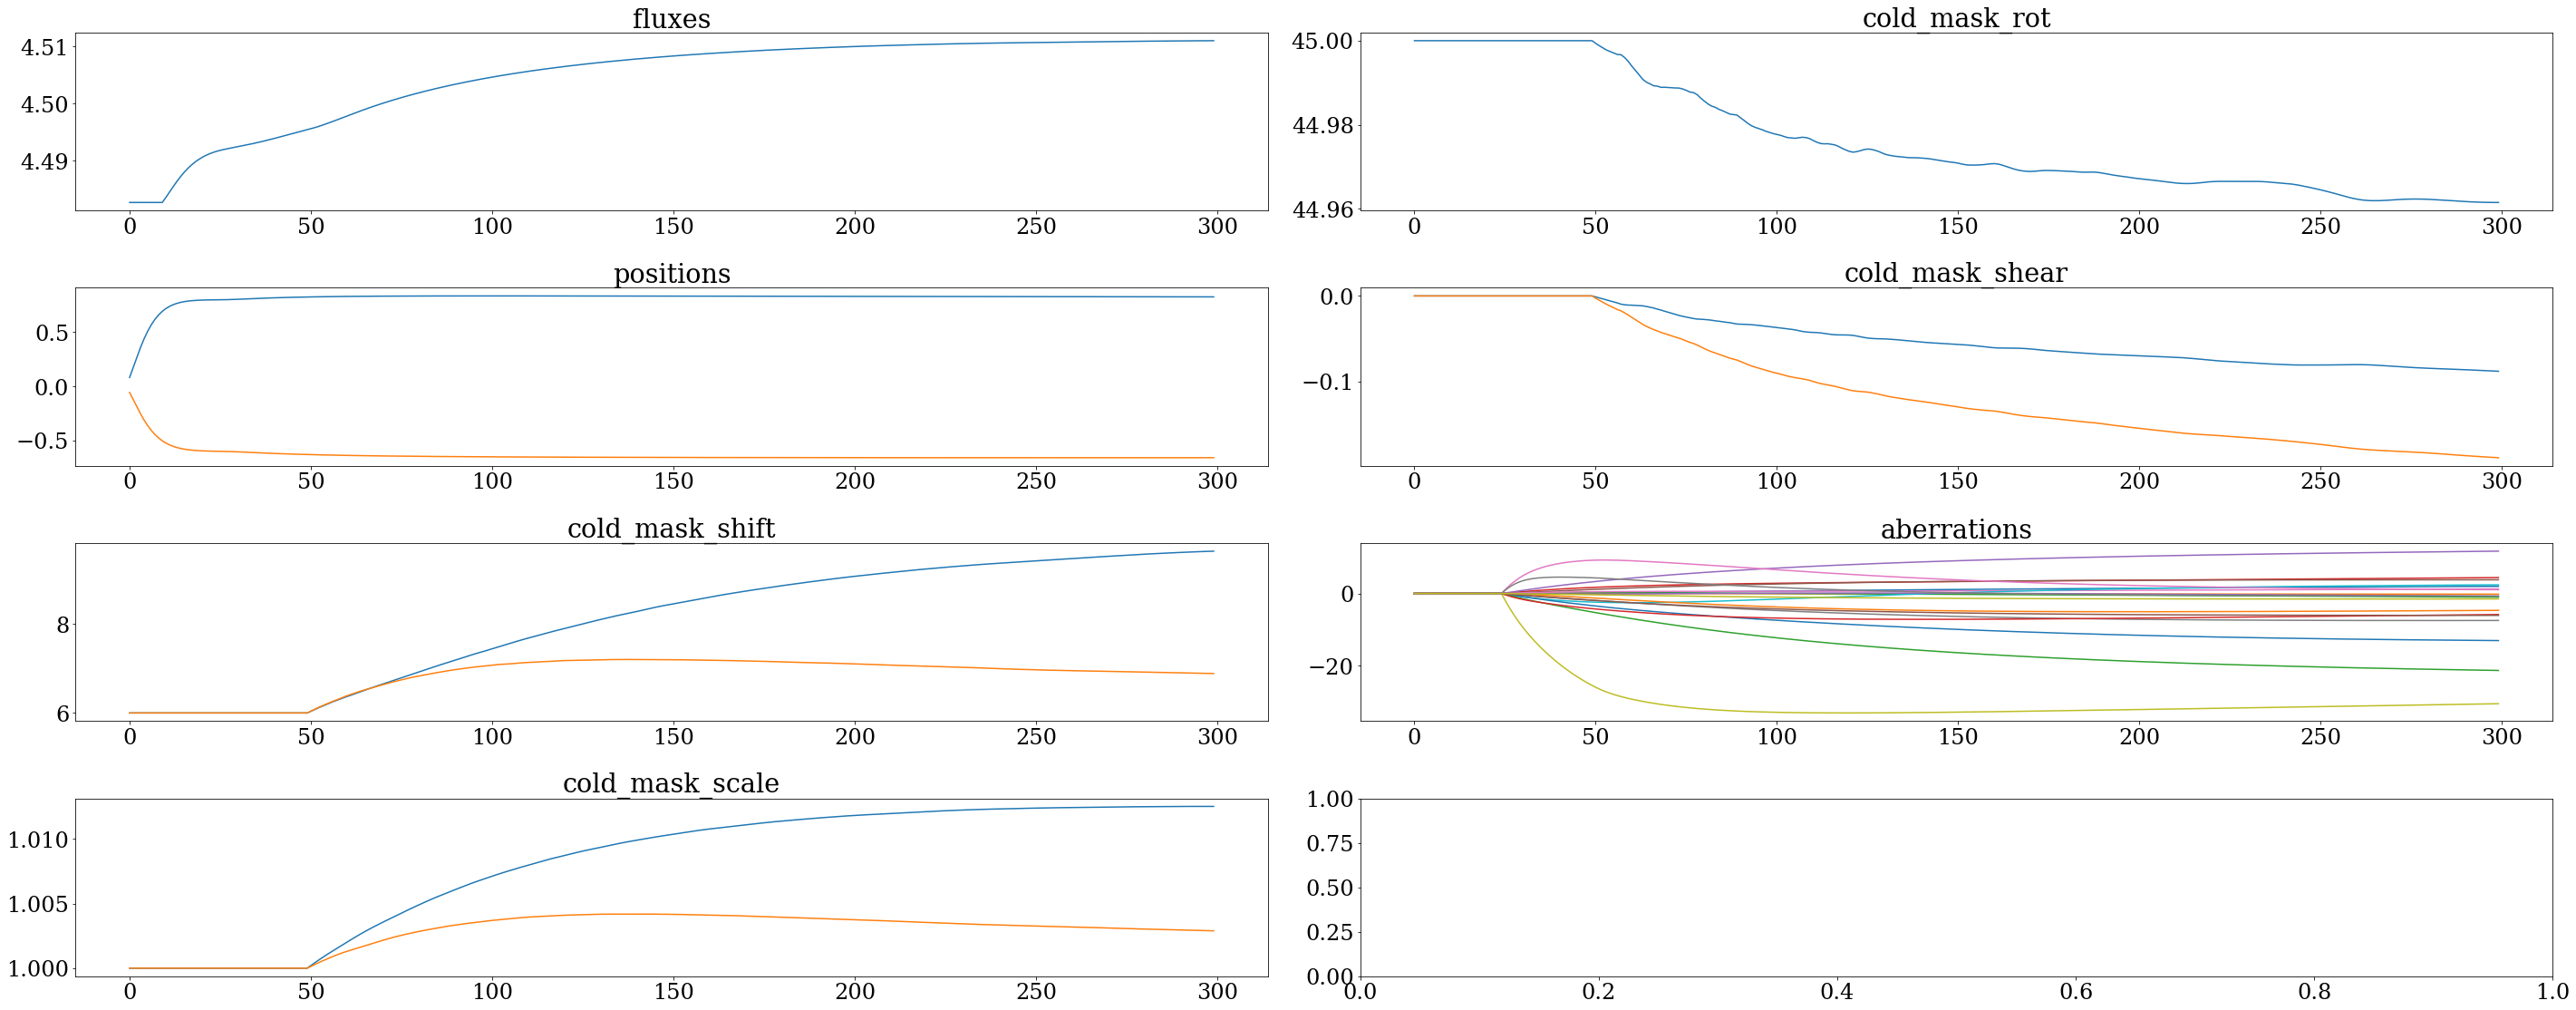

In [157]:
xw = 4
yw = int(np.ceil(len(groups)/xw))

print(len(groups))


fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups):
    #print(param)
    sp = axs[i%xw, i//xw]
    if param in ["fluxes", "contrast", "positions", "aberrations", 
                 "cold_mask_shift", "cold_mask_rot", "cold_mask_scale", "cold_mask_shear",
                 "primary_rot","primary_scale", "primary_shear", "breathing"]:
        #print(np.asarray(list(models_s[0].get(param).values())))
        #print(injected_params[param])
        """for j in injected_params[param].values():
            print(j)
            print(len(j.shape))
            if len(j.shape)>0:
                for k in j:
                    sp.axhline(k, color='k', linestyle='--')
            else:
                sp.axhline(j, color='k', linestyle='--')"""
        for p in np.asarray([np.asarray(list(x.get(param).values())) for x in models]).T:
            if len(p.shape)>1:
                for i in range(p.shape[0]):
                    sp.plot(p[i,:])
            else:
                sp.plot(p)
            sp.set_title(param)
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models])
        #sp.axhline(injected_params[param], color='k', linestyle='--')

    
fig.tight_layout()

7.625694e+07, 1.516496e+05


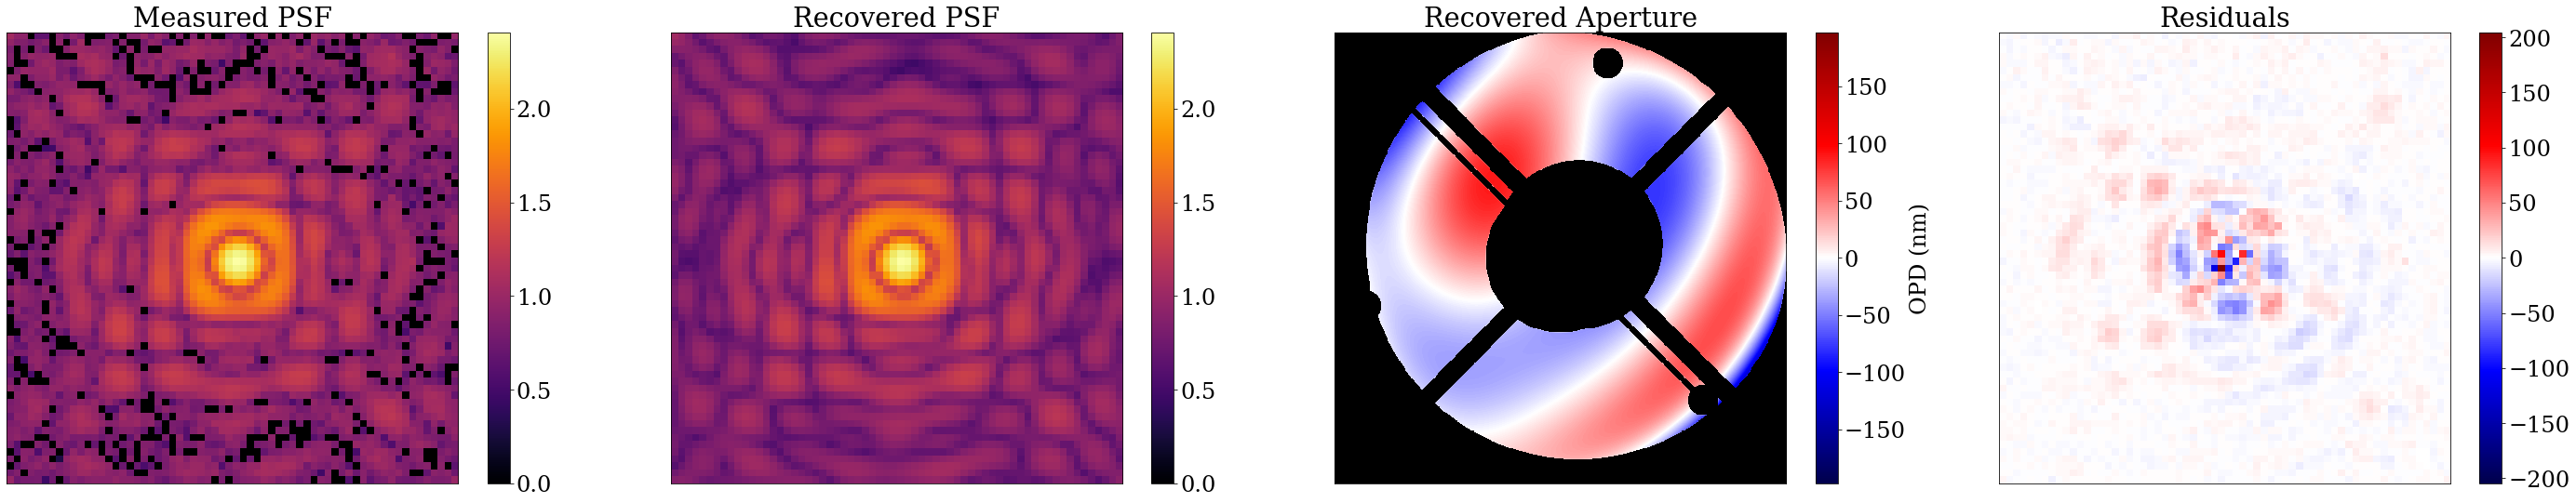

In [158]:
print(f"{float(losses[0]):e}, {float(losses[-1]):e}")

fig, axs = plt.subplots(1,4, figsize=(40,8))

fig.tight_layout()

cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)

#vm = max(np.max(cropped_data),np.max(telescope.model()))

exp = exposures[0]

model = params.inject(model)

coords = dlu.pixel_coords(512, 2.4)
cropped_frame = exp.data**0.125
telescope_frame = exp.fit(model,exp)**0.125

vm = max(np.nanmax(cropped_frame),np.nanmax(telescope_frame))
cd=axs[0].imshow(cropped_frame, vmin=0,vmax=vm,cmap=cmap)
plt.colorbar(cd,ax=axs[0])
tl=axs[1].imshow(telescope_frame, vmin=0, vmax=vm,cmap=cmap)
plt.colorbar(tl,ax=axs[1])
#axs[2].imshow(cropped_err)
cmap = matplotlib.colormaps['seismic']
cmap.set_bad('k',1)

#start_aberrations = model.get(exp.fit.map_param(exp, "start_aberrations"))#*1e-9
#end_aberrations = model.get(exp.fit.map_param(exp, "end_aberrations"))#*1e-9

#aberrations_model = model.set(exp.map_param("aberrations"), (start_aberrations+end_aberrations)/2)

optics = exp.fit.update_optics(model, exp)

support = optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd = optics.AberratedAperture.eval_basis(coords)*1e9
olim = np.max(np.abs(opd))
apt =axs[2].imshow(support_mask*opd,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[2]).set_label("OPD (nm)")
#axs[4].imshow(telescope.detector.pixel_response.pixel_response)
resid = (exp.data - exp.fit(model,exp))/exp.err
rlim = np.nanmax(np.abs(resid))
resid=axs[3].imshow(resid, cmap='seismic',vmin=-rlim, vmax=rlim)
plt.colorbar(resid,ax=axs[3])

axs[0].set_title("Measured PSF")
axs[1].set_title("Recovered PSF")
axs[2].set_title("Recovered Aperture")
axs[3].set_title("Residuals")

for i in range(4):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

#axs[1].imshow(telescope.optics.aberrations.eval_basis(coords)*1e9)
plt.show()
#plt.imshow(np.abs(telescope.model()-cropped_data)**0.25)


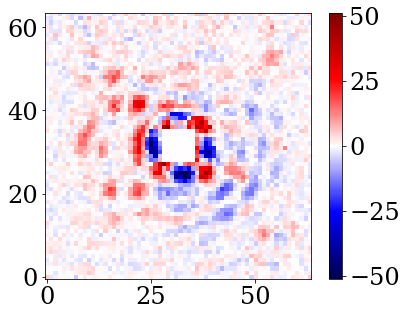

In [159]:
resid = (exp.data - exp.fit(model,exp))/exp.err

bresid = resid.at[28:36, 28:36].set(0)
vm = np.nanmax(np.abs(bresid))
plt.imshow(bresid, cmap='seismic', vmin=-vm, vmax=vm)

#print(np.nanmedian(np.abs(resid[50:-50,50:-50])))
#plt.imshow((np.abs(resid[50:-50,50:-50])))
plt.colorbar()

In [160]:
np.sort(resid.flatten())[::-1][:50]

Array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 204.54404 ,
       100.129196,  85.45897 ,  54.544956,  47.22452 ,  46.96744 ,
        45.688667,  44.562954,  42.381516,  41.62275 ,  41.527622,
        40.997993,  40.158077,  40.00741 ,  37.930813,  37.796463,
        36.399494,  36.052975,  35.297947,  34.73283 ,  34.643005,
        34.424534,  34.166313,  33.94196 ,  33.666706,  32.347157,
        31.952644,  31.406197,  30.659424,  30.428116,  30.218319,
        30.10605 ,  29.724682,  29.583193,  28.993269,  28.747435,
        28.630375,  28.408846,  27.866514,  27.307062,  27.29508 ],      dtype=float32)

In [161]:
if new_nans:
    nanmap = np.ones((wid,wid))
    for i in tqdm(range(10)):
        lpdf = posterior(model,exp,return_im=True)*nanmap
        ind = np.unravel_index(np.nanargmax(lpdf),lpdf.shape)
        nanmap = nanmap.at[ind].set(np.nan)

    

    bad = np.isnan(lpdf)

  0%|          | 0/10 [00:00<?, ?it/s]

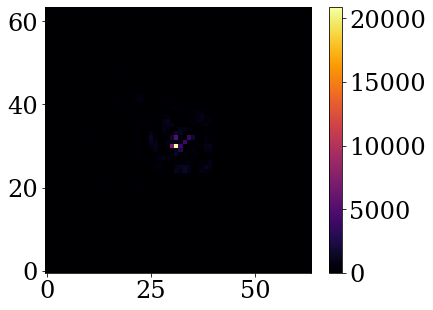

In [162]:
lpdf = posterior(model,exp,return_im=True)#*nanmap
plt.imshow(lpdf)
plt.colorbar()

In [163]:
"""fig, axs = plt.subplots(1,3, figsize=(32,8))
fig.tight_layout()

cmap = matplotlib.colormaps['seismic']
cmap.set_bad('k',1)


model = ModelParams(injected_params).inject(model)
optics = exp.fit.update_optics(model, exp)

support = optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd_t = optics.AberratedAperture.eval_basis(coords)*1e9
olim = np.max(np.abs(opd_t))
apt =axs[0].imshow(support_mask*opd_t,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[0]).set_label("OPD (nm)")

model = params.inject(model)
optics = exp.fit.update_optics(model, exp)

support = optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd_r = optics.AberratedAperture.eval_basis(coords)*1e9
olim = np.max(np.abs(opd_r))
apt =axs[1].imshow(support_mask*opd_r,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[1]).set_label("OPD (nm)")

resid = opd_t - opd_r
olim = np.max(np.abs(resid))
apt =axs[2].imshow(resid,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[2]).set_label("residual (nm)")
axs[2].set_title("Aberration Residuals")
axs[1].set_title("Recovered Aberrations")
axs[0].set_title("Injected Aberrations")

"""


'fig, axs = plt.subplots(1,3, figsize=(32,8))\nfig.tight_layout()\n\ncmap = matplotlib.colormaps[\'seismic\']\ncmap.set_bad(\'k\',1)\n\n\nmodel = ModelParams(injected_params).inject(model)\noptics = exp.fit.update_optics(model, exp)\n\nsupport = optics.transmission(coords,2.4/512)\nsupport_mask = support.at[support < .5].set(np.nan)\n\nopd_t = optics.AberratedAperture.eval_basis(coords)*1e9\nolim = np.max(np.abs(opd_t))\napt =axs[0].imshow(support_mask*opd_t,cmap=cmap,vmin=-olim, vmax=olim)\nplt.colorbar(apt, ax=axs[0]).set_label("OPD (nm)")\n\nmodel = params.inject(model)\noptics = exp.fit.update_optics(model, exp)\n\nsupport = optics.transmission(coords,2.4/512)\nsupport_mask = support.at[support < .5].set(np.nan)\n\nopd_r = optics.AberratedAperture.eval_basis(coords)*1e9\nolim = np.max(np.abs(opd_r))\napt =axs[1].imshow(support_mask*opd_r,cmap=cmap,vmin=-olim, vmax=olim)\nplt.colorbar(apt, ax=axs[1]).set_label("OPD (nm)")\n\nresid = opd_t - opd_r\nolim = np.max(np.abs(resid))\napt =

In [164]:
params.params

{'aberrations': {'n43ca5feq': Array([  1.9805312 ,  -0.18335393,  -1.0153775 ,   4.406505  ,
          11.726224  ,   3.7957184 ,   1.2508667 ,  -7.4754815 ,
         -30.541945  ,   2.412988  , -13.0434675 ,  -4.6792164 ,
         -21.322643  ,  -5.829957  ,  -0.7086347 ,  -6.063102  ,
           1.0436665 ,  -0.7148576 ,  -1.503717  ], dtype=float32)},
 'cold_mask_rot': {'F190N': Array(44.961506, dtype=float32)},
 'cold_mask_scale': {'F190N': Array([1.0125065, 1.0028905], dtype=float32)},
 'cold_mask_shear': {'F190N': Array([-0.08796688, -0.18889529], dtype=float32)},
 'cold_mask_shift': {'F190N': Array([9.6375265, 6.8858953], dtype=float32)},
 'fluxes': {'F190N': Array(4.51099, dtype=float32)},
 'outer_radius': 1.146,
 'positions': {'n43ca5feq': Array([ 0.82444865, -0.6586028 ], dtype=float32)},
 'primary_rot': {'F190N': 45.0},
 'primary_scale': {'F190N': Array([1., 1.], dtype=float32)},
 'primary_shear': {'F190N': Array([0., 0.], dtype=float32)},
 'rot': 0.0,
 'scale': 0.0434735,
 

In [165]:
np.log10(list(params.params["fluxes"].values())[0])

Array(0.65427184, dtype=float32)